# 2<sup>nd</sup> Order Solutions CFPB Case Study (written in Python 3)
<b>Yifeng Song</b>, Master's Student at University of Virginia Data Science Institute<br>
<b>10/31/2016</b>

In [1]:
import os
os.chdir('/home/composersyf/Documents/2OS Case Study') #To test the code in this notebook, change the file directory first

In [2]:
import numpy as np
import pandas as pd

from collections import Counter
import re

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Directly read in the raw data from the url of the CFPB database, and load it as a DataFrame in pandas
complaints_raw=pd.read_csv("https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv",low_memory=False)

#### Several helper functions:

In [4]:
def split_date(date):
    #split the date MM/DD/YYYY into month, day and year
    return tuple(date.split('/'))

def extract_value(date,value_type):
    #extract the year, month or day value from the raw date format
    if value_type=='year':
        return date.split('/')[2]
    elif value_type=='month':
        return date.split('/')[0]
    elif value_type=="day":
        return date.split('/')[1]
    else:
        return "Wrong value_type input!"

def is_element(e, l):
    #test if an object e is an element of the list l
    if e in l:
        return True
    else:
        return False
    
def check_zipcode_5_digit(code):
    #test if the zipcode satisfy the 5-digit format #####
    if pd.isnull(code):
        return False
    else:
        try:
            re.match('[0-9]{5}',code).group(0)
            return True
        except AttributeError:
            return False
    
def check_zipcode_3_digit(code):
    #test if the zipcode satisfy the 3-digit format #####
    if pd.isnull(code):
        return False
    else:
        try:
            re.match('[0-9]{3}XX',code).group(0)
            return True
        except AttributeError:
            return False
        
def string_length(s):
    # return the length of the string (or other data types that can be converted into string);
    # if the input is N/A, then the function will return N/A
    if pd.isnull(s):
        return np.nan
    else:
        return int(len(str(s)))
    
def check_date_format(date):
    # check the input date value follows the format MM/DD/YYYY
    try:
        re.match('[0-9]{2}/[0-9]{2}/[0-9]{4}',date).group(0)
        return True
    except (AttributeError,TypeError): #if the input date is N/A, the above in the try block will raise TypeError
        return False
    
def extract_first_character(string):
    #extract the first character of a string, useful for searching for Company names in the data
    return string[0]

def encode_categorical_variable(value,reverse=False):
    if pd.isnull(value):
        return np.nan
    elif value=='Yes':
        if reverse:
            return 0
        else:
            return 1
    elif value=='No':
        if reverse:
            return 1
        else:
            return 0
        
def plot_issue_dist(bank,indx,complaints):
    #plot the top 10 issue types as well as their proportions for a given bank
    df=complaints[complaints.Company==bank]
    top10_issues=df.groupby(['Issue']).size().sort_values(ascending=False).head(10)/df.shape[0]*100
    bar_plot=top10_issues.plot(ax=indx,kind='bar',fontsize=12)
    bar_plot.set_xlabel('Issue',fontsize=16)
    bar_plot.set_ylabel('Proportion%',fontsize=16)
    bar_plot.set_title(bank,fontsize=18)

def plot_two_graphs_together(i,complaints,bank_list):
    #plot two graphs next to each other for comparison purposes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    plot_issue_dist(bank_list[i],axes[0],complaints)
    plot_issue_dist(bank_list[i+1],axes[1],complaints)

In [5]:
#add a new column to table which shows the year when the complaint was received
complaints_raw['Year received']=complaints_raw['Date received'].apply(extract_value,args=("year",))

In [6]:
#restrict the data to the time period: January 2013 to December 2015
complaints_1=complaints_raw[complaints_raw['Year received'].apply(is_element, args=(['2013','2014','2015'],))]
complaints_1=complaints_1.sort_values(['Date received']) #sort the table by 'Date received'
complaints_1.head(15) #top 15 rows of the resulting table

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received
550513,01/01/2013,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,NaN,Equifax,WA,98520,NaN,NaN,Web,01/02/2013,Closed with explanation,Yes,No,215977,2013
270582,01/01/2013,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Wells Fargo & Company,OH,44053,Older American,NaN,Web,01/02/2013,Closed with explanation,Yes,No,219493,2013
270576,01/01/2013,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,NaN,Experian,CA,92821,NaN,NaN,Web,12/31/2012,Closed with explanation,Yes,No,219486,2013
270571,01/01/2013,Mortgage,Other mortgage,Other,NaN,NaN,NaN,"Bayview Loan Servicing, LLC",PA,17404,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219479,2013
270570,01/01/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"Seterus, Inc.",CA,96002,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219476,2013
270569,01/01/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,TD Bank US Holding Company,CT,06851,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219474,2013
270557,01/01/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,U.S. Bancorp,OR,97045,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219472,2013
270546,01/01/2013,Mortgage,Second mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,CA,94536,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219457,2013
270544,01/01/2013,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,NaN,Bank of America,CA,92345,NaN,NaN,Referral,01/02/2013,Closed with monetary relief,Yes,No,219456,2013
270543,01/01/2013,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,NaN,U.S. Bancorp,WA,98056,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219450,2013


In [7]:
complaints_1.shape[0] #total number of complaints during 2013/01 - 2015/12

429916

## Problem 1

#### (0) Check the column 'Date received'

In [8]:
#Check the 'Date received' to see if there is any value which is N/A or does not conform to the MM/DD/YYYY format
complaints_1[np.array(~complaints_1['Date received'].apply(check_date_format)) \
             | np.array(complaints_1['Date received'].apply(string_length)!=10)]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received


Empty table indicates that all date values in this column are fine. So 'Date received' column is good.

#### (1) check the columns 'Product' and 'Sub-product'

In [9]:
#use '--' to concatenate Product and Sub-product
pd.DataFrame.from_dict(Counter(complaints_1['Product'].apply(str)+' -- '+complaints_1['Sub-product']\
                               .apply(str)),orient='index').sort_index().rename(columns={0:"Counts"})

,Counts
Bank account or service -- (CD) Certificate of deposit,1838
Bank account or service -- Cashing a check without an account,328
Bank account or service -- Checking account,31677
Bank account or service -- Other bank product/service,8507
Bank account or service -- Savings account,2844
Consumer Loan -- Installment loan,4278
Consumer Loan -- Pawn loan,52
Consumer Loan -- Personal line of credit,1036
Consumer Loan -- Title loan,277
Consumer Loan -- Vehicle lease,1304


<b>Oddity Type 1</b>: Some Products has no Sub-product category ('Credit card', 'Credit report'); some other Products only have one of their Sub-product categories in the current table ('Student loan', 'Virtual currency'); For 'Payday loan', its Sub-product is also named 'Payday loan', so it is very likely that 'Payday loan' does not actually have a Sub-category, and by checking the 'Submit a complaint' webpage (http://www.consumerfinance.gov/complaint/), I also confirmed that 'Payday loan' does not have a Sub-product. So the 'Payday loan' values in the Sub-product column can be replaced by N/A, so that N/A in Sub-product column will always indicate that the Product does not have a Sub-product, being in consistency with other Products. The rest of the Product types are OK. 

In [10]:
#Solution: replace any "Payday loan -- Payday loan" by "Payday loan -- nan"
indices=np.where(np.array(complaints_1.Product=="Payday loan") & np.array(complaints_1['Sub-product']=="Payday loan"))[0]
complaints_1.iloc[indices,2]=np.nan #column index of Sub-product is 2

#### (2) check the columns 'Issue' and 'Sub-issue'

In [11]:
#Check the Issue column first
np.unique(complaints_1.Issue)

array(['APR or interest rate', 'Account opening, closing, or management',
       'Account terms and changes', 'Adding money',
       'Advertising and marketing',
       'Advertising, marketing or disclosures',
       'Application processing delay',
       'Application, originator, mortgage broker',
       'Applied for loan/did not receive money', 'Arbitration',
       'Balance transfer', 'Balance transfer fee', 'Bankruptcy',
       'Billing disputes', 'Billing statement', "Can't contact lender",
       "Can't repay my loan", "Can't stop charges to bank account",
       'Cash advance', 'Cash advance fee',
       'Charged bank acct wrong day or amt',
       "Charged fees or interest I didn't expect",
       'Closing/Cancelling account', 'Collection debt dispute',
       'Collection practices', 'Communication tactics',
       "Cont'd attempts collect debt not owed", 'Convenience checks',
       'Credit card protection / Debt protection',
       'Credit decision / Underwriting', 'Credit de

<b>Oddity Type 2</b>: two entries are essentially the same, and will be treated as different Issue types if one of them is made to be equal to the other. In this case, 'Customer service / Customer relations' and 'Customer service/Customer relations' are the same. To solve this oddity, all 'Customer service/Customer relations' will be replaced by 'Customer service / Customer relations'. 

In [12]:
#Solution to Oddity Type 2:
indices=np.where(complaints_1.Issue=="Customer service/Customer relations")[0]
complaints_1.iloc[indices,3]='Customer service / Customer relations'

In [13]:
#Next, check the combination of Issue and Sub-issue
issues=pd.DataFrame.from_dict(Counter(complaints_1.Issue.apply(str)+' -- '+complaints_1['Sub-issue'].apply(str)),orient='index').sort_index().rename(columns={0:'Counts'}).reset_index([0])#.iloc[:,0].apply(str.split,args=(" -- ",))
issues

,index,Counts
0,APR or interest rate -- nan,2485
1,"Account opening, closing, or management -- nan",19433
2,Account terms and changes -- nan,295
3,Adding money -- nan,135
4,Advertising and marketing -- nan,1610
5,"Advertising, marketing or disclosures -- nan",35
6,Application processing delay -- nan,258
7,"Application, originator, mortgage broker -- nan",9433
8,Applied for loan/did not receive money -- Appl...,239
9,Applied for loan/did not receive money -- nan,22


#some Issue types have two Sub-issues, but one of the Sub-issue has the same name as the Issue, the other Sub-issue is just N/A; So most likely, there are <b>Oddity Type 1</b> present

In [14]:
#find all Oddity Type 1 cases:
issue_subissue=pd.DataFrame(list(issues['index'].apply(str.split,args=(' -- ',)).apply(tuple))).rename(columns={0:'Issue',1:'Sub-issue'})
subissue_counts=Counter(issue_subissue['Issue'])
check_list=[]
for i in subissue_counts:
    if subissue_counts[i]==2:
        check_list.append(i)
two_subissue=issue_subissue[issue_subissue['Issue'].apply(is_element,args=(check_list,))]
two_subissue

,Issue,Sub-issue
8,Applied for loan/did not receive money,Applied for loan/did not receive money
9,Applied for loan/did not receive money,nan
16,Can't contact lender,Can't contact lender
17,Can't contact lender,nan
21,Can't stop charges to bank account,Can't stop charges to bank account
22,Can't stop charges to bank account,nan
25,Charged bank acct wrong day or amt,Charged bank acct wrong day or amt
26,Charged bank acct wrong day or amt,nan
27,Charged fees or interest I didn't expect,Charged fees or interest I didn't expect
28,Charged fees or interest I didn't expect,nan


All the above Issue types might have <b>Oddity Type 1</b> except 'Unable to get credit report/credit score'. 

In [15]:
check_list=np.unique(two_subissue.Issue)[:-1]
check_list

array(['Applied for loan/did not receive money', "Can't contact lender",
       "Can't stop charges to bank account",
       'Charged bank acct wrong day or amt',
       "Charged fees or interest I didn't expect",
       'Payment to acct not credited',
       'Problems when you are unable to pay',
       "Received a loan I didn't apply for"], dtype=object)

One example for <b>Oddity Type 1</b> within the Issue/Sub-issue pair. By checking the 'Submit a complaint' webpage (http://www.consumerfinance.gov/complaint/), it can be confirmed that those issues in the check_list do have no Sub-issues. So they have the <b>Oddity Type 1</b>. So similar as the Product/Sub-product case, those Sub-issues whose name is the same as the Issue should be replaced by N/A so as to avoid confusion

In [16]:
complaints_1[complaints_1.Issue==check_list[0]].loc[:,['Product','Sub-product','Issue','Sub-issue']].drop_duplicates()

,Product,Sub-product,Issue,Sub-issue
430545,Payday loan,NaN,Applied for loan/did not receive money,Applied for loan/did not receive money
193718,Consumer Loan,Title loan,Applied for loan/did not receive money,NaN
56841,Consumer Loan,Pawn loan,Applied for loan/did not receive money,NaN


In [17]:
#Solution to Oddity Type 1 within the Sub-issue column:
for issue in check_list:
    indices=np.where(np.array(complaints_1.Issue==issue) & np.array(complaints_1['Sub-issue']==issue))[0]
    complaints_1.iloc[indices,4]=np.nan

In [18]:
#Finally, print out all of the cleaned Issue/Sub-issue pairs to make sure that everything looks good
issues_cleaned=pd.DataFrame.from_dict(Counter(complaints_1.Issue.apply(str)+' -- '+complaints_1['Sub-issue'].apply(str)),orient='index').sort_index().rename(columns={0:'Counts'}).reset_index([0])#.iloc[:,0].apply(str.split,args=(" -- ",))
for i in issues_cleaned['index']:
    print(i)

APR or interest rate -- nan
Account opening, closing, or management -- nan
Account terms and changes -- nan
Adding money -- nan
Advertising and marketing -- nan
Advertising, marketing or disclosures -- nan
Application processing delay -- nan
Application, originator, mortgage broker -- nan
Applied for loan/did not receive money -- nan
Arbitration -- nan
Balance transfer -- nan
Balance transfer fee -- nan
Bankruptcy -- nan
Billing disputes -- nan
Billing statement -- nan
Can't contact lender -- nan
Can't repay my loan -- Can't decrease my monthly payments
Can't repay my loan -- Can't get flexible payment options
Can't repay my loan -- Can't temporarily postpone payments
Can't stop charges to bank account -- nan
Cash advance -- nan
Cash advance fee -- nan
Charged bank acct wrong day or amt -- nan
Charged fees or interest I didn't expect -- nan
Closing/Cancelling account -- nan
Collection debt dispute -- nan
Collection practices -- nan
Communication tactics -- Called after sent written cea

Every pair looks reasonable now!

#### (3) check the columns 'Consumer complaint narrative' and 'Consumer consent provided?'

In [19]:
len(complaints_1['Consumer complaint narrative'][pd.isnull(complaints_1['Consumer complaint narrative'])])
#total number of N/A entries in the 'Consumer complaint narrative'

375076

According to the data dictionary, if the value of 'Consumer consent provided?' is not equal to 'Consent provided', the value of 'Consumer complaint narrative' must be N/A. Otherwise there are privacy issues. The following code check if there are such exceptions. The result is an empty table, which confirms that there are no complaint narratives which are incorrectly made public.

In [20]:
complaints_1[np.array(~pd.isnull(complaints_1['Consumer complaint narrative'])) \
             & np.array(complaints_1['Consumer consent provided?']!='Consent provided')]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received


On the other hand, if the value of 'Consumer consent provided' is equal to 'Consent provided', the value of 'Consumer complaint narrative' must not be empty. The following code check if there are such exceptions. The result is an empty table, which confirms that there are complaint narratives which are supposed to be made public but actually not. 

In [21]:
complaints_1[np.array(pd.isnull(complaints_1['Consumer complaint narrative'])) \
             & np.array(complaints_1['Consumer consent provided?']=='Consent provided')]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received


In [22]:
Counter(complaints_1['Consumer consent provided?'])

Counter({nan: 330283,
         'Consent provided': 54840,
         'Consent not provided': 41583,
         'Consent withdrawn': 4,
         'Other': 3206})

All values within the column 'Consumer consent provided?' look normal.

#### (4) check the columns 'Consumer public response', 'Company', 'State', Zip code', 'Tags'

In [23]:
Counter(complaints_1['Company public response'])

Counter({nan: 368061,
         'Company believes complaint relates to a discontinued policy or procedure': 22,
         'Company believes it acted appropriately as authorized by contract or law': 11500,
         'Company believes complaint is the result of an isolated error': 732,
         'Company believes complaint represents an opportunity for improvement to better serve consumers': 371,
         'Company has responded to the consumer and the CFPB and chooses not to provide a public response': 32,
         'Company chooses not to provide a public response': 45081,
         'Company disputes the facts presented in the complaint': 1074,
         "Company can't verify or dispute the facts in the complaint": 871,
         'Company believes complaint caused principally by actions of third party outside the control or direction of the company': 1182,
         'Company believes the complaint is the result of a misunderstanding': 990})

All values in the column 'Consumer public response' look good.

In [24]:
pd.DataFrame.from_dict(Counter(complaints_1['Company']),orient='index').sort_index().rename(columns={0:'Counts'})

,Counts
"(Former)Shapiro, Swertfeger & Hasty, LLP",4
"1st 2nd Mortgage Company Of NJ, Inc.",1
1st Alliance Lending,9
"1st Capital Mortgage, LLC",1
1st Fidelity Loan Servicing,5
1st Franklin Financial Corporation,38
1st Maryland Mortgage Corporation,1
1st Midwest Mortgage Corp,1
"1st Money Center, Inc.",2
1st Portfolio Holding Corporation,1


Most company names begin with letters. For those companies whose names begin with numbers, their names all look reasonable. 

In [25]:
#Check 'State' column
state_column=pd.DataFrame.from_dict(Counter(complaints_1['State']),orient='index').sort_index().rename(columns={0:'Counts'})
for i in range(state_column.shape[0]):
    print(state_column.index[i],state_column.iloc[i,0])

AA 8
AE 184
AK 499
AL 4520
AP 130
AR 1907
AS 12
AZ 9498
CA 62261
CO 7355
CT 4853
DC 2520
DE 2281
FL 41319
FM 26
GA 18714
GU 55
HI 1535
IA 1762
ID 1482
IL 15164
IN 4814
KS 2064
KY 3142
LA 4331
MA 8262
MD 13484
ME 1448
MH 22
MI 11010
MN 4861
MO 5620
MP 16
MS 2061
MT 695
NC 12111
ND 376
NE 1340
NH 1973
NJ 17374
NM 2164
NV 5410
NY 29119
OH 13415
OK 2912
OR 5172
PA 15714
PR 1017
PW 7
RI 1475
SC 5534
SD 596
TN 6633
TX 33581
UT 2324
VA 14217
VI 107
VT 707
WA 8976
WI 4760
WV 1127
WY 438
nan 3422


In [26]:
# Total number of categories in the State column
len(Counter(complaints_1.State))

63

There are 3,422 consumers whose State information is missing. This is not a big issue, unless we are really concerned about the geographic distribution of the consumers who submitted complaints. There are 62 'States' left, including those which are not actually a US State, but the overseas territories (e.g. 'PR' stands for Puerto Rico) and military mail codes. So the 'State' column is fine.

In [27]:
#Check 'ZIP code' column:
#detect any zip code that does not have 5 digits and not N/A
complaints_1[np.array(complaints_1['ZIP code'].apply(string_length)!=5) & np.array(~pd.isnull(complaints_1['ZIP code']))]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received
559121,09/12/2014,Other financial service,Traveler’s/Cashier’s checks,Lost or stolen check,NaN,NaN,NaN,Amex,CA,9212,NaN,NaN,Phone,09/17/2014,Closed with explanation,Yes,Yes,1027429,2014


Found <b>Oddity Type 3</b>: illegal ZIP code format
The above zip code only contains 4 digits, according to the data dictionary, 4 digits zip code is not allowed.

In [28]:
#detect any zip code that is not purely 5-digit or 3-digit(###XX):
complaints_1[np.array(~complaints_1['ZIP code'].apply(check_zipcode_5_digit)) \
             & np.array(~complaints_1['ZIP code'].apply(check_zipcode_3_digit)) \
             & np.array(~pd.isnull(complaints_1['ZIP code']))
             & np.array(complaints_1['ZIP code'].apply(string_length)==5)]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received
552064,01/11/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,PNC Bank N.A.,MD,2113-,NaN,NaN,Referral,01/14/2013,Closed with explanation,Yes,No,227331,2013
471995,01/14/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Ocwen,MD,2077,NaN,NaN,Referral,01/16/2015,Closed with explanation,Yes,No,1192356,2015
52015,01/16/2015,Debt collection,Credit card,Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,Bank of America,NY,1001-,NaN,NaN,Postal mail,01/21/2015,Closed with explanation,Yes,No,1196605,2015
51884,01/16/2015,Credit reporting,NaN,Incorrect information on credit report,Account terms,NaN,NaN,Equifax,CA,9`325,NaN,NaN,Web,01/20/2015,Closed with explanation,Yes,Yes,1197509,2015
333951,01/26/2015,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"Select Portfolio Servicing, Inc",CA,[9507,NaN,NaN,Web,01/29/2015,Closed with explanation,Yes,Yes,1210800,2015
54433,01/27/2015,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,NaN,"Cascade Capital, LLC",TX,7611,Older American,NaN,Phone,01/30/2015,Closed with non-monetary relief,Yes,No,1211969,2015
410891,01/31/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Citibank,CA,202-0,Older American,NaN,Web,01/31/2013,Closed with explanation,Yes,No,278667,2013
412993,02/01/2013,Credit card,NaN,Billing disputes,NaN,NaN,NaN,BBVA Compass,FL,3222.,NaN,NaN,Referral,02/01/2013,Closed with explanation,Yes,No,283054,2013
154771,02/01/2014,Credit reporting,NaN,Credit reporting company's investigation,Problem with statement of dispute,NaN,NaN,"TransUnion Intermediate Holdings, Inc.",WI,5437-,NaN,NaN,Web,02/05/2014,Closed with explanation,Yes,No,695545,2014
194533,02/05/2015,Credit reporting,NaN,Credit monitoring or identity protection,Billing dispute,NaN,NaN,"TransUnion Intermediate Holdings, Inc.",MT,5981`,NaN,NaN,Web,02/06/2015,Closed with explanation,Yes,No,1226270,2015


There are 157 complaints whose comsumer's ZIP code does not comply with the allowed pattern as defined in the data dictionary (also <b>Oddity Type 3</b>). Those zip codes, together with the above 4-digit zip code case, should be replaced by N/A since data dictionary says that the ZIP code entry is blank if ZIP codes have been submitted with non-numeric values. In this case study, the issues with the ZIP code column is not quite revelant. But if we were required to find the location where the complaint was sent by zip code lookup (as certain issues might be closely related to the location), those zip codes which do not follow the 5-digit or 3-digit pattern will mess up the program, provided they are not properly handled. Even if one could find part of the information from the incomplete zip codes, the irregularity of these codes adds to the complexity and difficulty of data processing. 

In [29]:
#Solutions to the above issue (Oddity Type 3):
indices=np.where((np.array(~complaints_1['ZIP code'].apply(check_zipcode_5_digit)) \
                  & np.array(~complaints_1['ZIP code'].apply(check_zipcode_3_digit)) \
                  & np.array(~pd.isnull(complaints_1['ZIP code'])) \
                  & np.array(complaints_1['ZIP code'].apply(string_length)==5)) \
                  | \
                 (np.array(complaints_1['ZIP code'].apply(string_length)!=5) \
                  & np.array(~pd.isnull(complaints_1['ZIP code']))))[0]
complaints_1.iloc[indices,9]=np.nan#column index for 'ZIP code' is 9

Next, all complaints with the consumer consent provided must have either the ###XX pattern or be blank, otherwise there will be privacy issues. So the following code tries to find any exceptions. 

In [30]:
complaints_1[np.array(complaints_1['Consumer consent provided?']=='Consent provided') \
             & np.array(complaints_1['ZIP code'].apply(check_zipcode_5_digit))]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received


The result is an empty table, so there are no potential privacy issues with the zip codes of the consumers who provided consent.

In [31]:
# Check 'Tags' column
Counter(complaints_1.Tags)

Counter({nan: 367451,
         'Servicemember': 21365,
         'Older American': 35998,
         'Older American, Servicemember': 5102})

In [32]:
np.array(complaints_1['Consumer consent provided?']=='Consent provided')

array([False, False, False, ...,  True,  True, False], dtype=bool)

'Tags' column looks reasonable, with the 'Older American, Servicemember' indicating the consumer belongs to the two categories simultaneously.

#### (5) check the columns 'Submitted via', 'Date sent to company', 'Complaint ID'

In [33]:
#Check the 'Submitted via' column
Counter(complaints_1['Submitted via'])

Counter({'Email': 176,
         'Fax': 6532,
         'Phone': 30036,
         'Postal mail': 28739,
         'Referral': 73357,
         'Web': 291076})

All categories in this column look reasonable. 

In [34]:
#Check the 'Date sent to company' to see if there is any value which is N/A or does not conform to the MM/DD/YYYY format
complaints_1[np.array(~complaints_1['Date sent to company'].apply(check_date_format)) \
             | np.array(complaints_1['Date sent to company'].apply(string_length)!=10)]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received


Empty table indicates that all date values in this column are fine. So 'Date sent to company' column is good.

In [35]:
#Check the 'Complaint ID' column:
print(len(complaints_1['Complaint ID'])==len(np.unique(complaints_1['Complaint ID']))) #there are no duplicate values in this column
print(sum(pd.isnull(complaints_1['Complaint ID']))) # there is no missing value in this column

True
0


'Complaint ID' column is good.

#### (6) check the columns 'Company response to consumer', 'Timely response?', 'Consumer disputed?'

In [36]:
#Check 'Timely response' column:
Counter(complaints_1['Timely response?'])

Counter({'No': 9819, 'Yes': 420097})

The value in this column is either yes or no, so 'Timely response?' column is fine.

In [37]:
#Check 'Company response to consumer':
Counter(complaints_1['Company response to consumer'])

Counter({'Closed': 10838,
         'Closed with explanation': 331062,
         'Closed with monetary relief': 28732,
         'Closed with non-monetary relief': 57552,
         'Untimely response': 1732})

The 'Company response to consumer' contains the 'Untimely response' as well, which might be an oddity. But the number of untimely response indicated by this column is only 1,732, which is much less than the number of untimely response indicated by the 'Timely response'.

In [38]:
# Check the intersection of the two 'untimely response' groups to see if they are overlapping with each other 
untimely=complaints_1.loc[:,['Company response to consumer', 'Timely response?']][\
                                                                                  np.array(complaints_1['Company response to consumer']=='Untimely response') \
                                                                                  & np.array(complaints_1['Timely response?']=='No')]
untimely.head(15)

,Company response to consumer,Timely response?
49099,Untimely response,No
271576,Untimely response,No
549328,Untimely response,No
468344,Untimely response,No
48337,Untimely response,No
12233,Untimely response,No
329672,Untimely response,No
50303,Untimely response,No
330289,Untimely response,No
469546,Untimely response,No


In [39]:
untimely.shape

(1732, 2)

The resulting table also contains 1,732 complaints, which means that all 'untimely response' entries in the 'Company response to consumer' column are also marked as untimely response in the 'Timely response?' column. Therefore, the 'Untimely response' value should not be present in the 'Company response to consumer' column, as it does not carry any useful information as we already have 'Timely reponse?'. In addition, for other ways in which the Company responded to the consumer, they can be either be timely or untimely. So the <b>Oddity Type 4</b> is found: 'Untimely response' is actually not a category of 'Company response to consumer', and they need to be replace by N/A in order to avoid any confusion, indicating that for these complaints we do not know how the company responded to the consumer. 

In [40]:
#Solution to Oddity Type 4:
indices=np.where(complaints_1['Company response to consumer']=='Untimely response')[0]
complaints_1.iloc[indices,14]=np.nan #column index of 'Company response to consumer' is 14

In [41]:
# Check 'Consumer disputed?' column:
Counter(complaints_1['Consumer disputed?'])

Counter({nan: 5592, 'No': 337714, 'Yes': 86610})

There are 5,601 complaints to which we do not know whether the consumer disputed company's response or not. But the total numer of missing values only occupies a small portion of the total number of complaints, so it is fine. 

## Problem 2

Sources used to estimate the number of customers for the 6 banks (2014 Total Revenue and Bank Total Deposits data): <br>
http://www.wikinvest.com/stock/Citigroup_%28C%29/Data/Bank_Total_Deposits/2014 <br>
http://www.wikinvest.com/stock/BB%26T_%28BBT%29/Data/Bank_Total_Deposits/2014 <br>
http://www.wikinvest.com/stock/SunTrust_Banks_%28STI%29/Data/Bank_Total_Deposits/2014 <br>
http://www.wikinvest.com/stock/U.S._Bancorp_%28USB%29/Data/Bank_Total_Deposits/2014 <br>
http://www.wikinvest.com/stock/Bank_of_America_%28BAC%29/Data/Bank_Total_Deposits/2014 <br>
http://www.wikinvest.com/stock/Discover_Financial_Services_%28DFS%29/Data/Bank_Total_Deposits/2014 <br>
http://www.wikinvest.com/stock/Citigroup_%28C%29/Data/Revenue/2014 <br>
http://www.wikinvest.com/stock/BB%26T_%28BBT%29/Data/Revenue/2014 <br>
http://www.wikinvest.com/stock/SunTrust_Banks_%28STI%29/Data/Revenue/2014 <br>
http://www.wikinvest.com/stock/U.S._Bancorp_%28USB%29/Data/Revenue/2014 <br>
http://www.wikinvest.com/stock/Bank_of_America_%28BAC%29/Data/Revenue/2014 <br>
http://www.wikinvest.com/stock/Discover_Financial_Services_%28DFS%29/Data/Revenue/2014 <br>
The data were collected from the above links and then saved into a file named "Six Banks.csv". <br>

The total number of customers (roughly) for Bank of America in 2014 is 47.5 million. This value is available in Page 8 of the Bank of America Annual Report for 2014 (http://about.bankofamerica.com/assets/pdf/annual-report-2014.pdf). I had searched the annual report as well as other related websites or documents to find the total number of customers of other 5 banks but did not successfully find such information. Due to the time constraints, I finally decided to use the revenue and total deposits of the 6 banks in 2014 which are readily available on the website of Wikinvest. Assuming the customer type distributions of each bank (in terms of average deposit per customer and the overall distribution across different customers) are very similar and the 6 six banks have similar proportions of their worldwide business in USA (which might not be true), we can approximately infer the other 5 banks' number of customers as long as we know Bank of America's number of customers by assuming that the number of customers is linearly proportional to the bank's revenue and total deposits. Same weights are assigned to the revenue and total deposits so as to reduce the error caused by the outliers in one measure). The data in Year 2014 are chosen as the time period for the customer satisfaction study is 2013.01 to 2015.12. 

In [42]:
#subset the data so that the table only includes the complaints data for the six banks to be investigated
six_banks=['Bank of America', 'Citibank', 'U.S. Bancorp', 'BB&T Financial', 'Discover','SunTrust Banks, Inc.']
complaints_6_banks=complaints_1[complaints_1.Company.apply(is_element,args=(six_banks,))]
complaints_6_banks.head(15)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year received
270557,01/01/2013,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,U.S. Bancorp,OR,97045,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219472,2013
270546,01/01/2013,Mortgage,Second mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,CA,94536,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219457,2013
270544,01/01/2013,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,NaN,Bank of America,CA,92345,NaN,NaN,Referral,01/02/2013,Closed with monetary relief,Yes,No,219456,2013
270543,01/01/2013,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,NaN,U.S. Bancorp,WA,98056,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219450,2013
270331,01/01/2013,Credit card,NaN,Credit determination,NaN,NaN,NaN,Bank of America,NY,11104,NaN,NaN,Web,01/02/2013,Closed with explanation,Yes,Yes,218917,2013
130609,01/01/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,TX,78209,NaN,NaN,Referral,01/02/2013,Closed with explanation,Yes,No,219458,2013
130610,01/01/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Bank of America,CA,95670,NaN,NaN,Referral,01/03/2013,Closed with non-monetary relief,Yes,No,219459,2013
130655,01/01/2013,Credit card,NaN,Credit determination,NaN,NaN,NaN,Citibank,FL,33525,Older American,NaN,Web,01/01/2013,Closed with explanation,Yes,No,219499,2013
130657,01/01/2013,Bank account or service,Checking account,Problems caused by my funds being low,NaN,NaN,NaN,BB&T Financial,MA,01810,Older American,NaN,Web,01/02/2013,Closed with monetary relief,Yes,No,219506,2013
130672,01/01/2013,Credit card,NaN,Late fee,NaN,NaN,NaN,Citibank,MO,63122,NaN,NaN,Web,01/03/2013,Closed with monetary relief,Yes,No,219516,2013


In [43]:
#calculate the total number of complaints for each of the six banks
num_of_complaints=pd.DataFrame({'Counts':complaints_6_banks.groupby(['Company']).size()}).reset_index([0])
num_of_complaints

,Company,Counts
0,BB&T Financial,1893
1,Bank of America,36579
2,Citibank,17848
3,Discover,3393
4,"SunTrust Banks, Inc.",3347
5,U.S. Bancorp,7269


Next, estimate the number of customers for each bank.

In [44]:
#read in the collected data from the web which contains total revenue and total deposits of each bank in 2014
bank_info=pd.read_csv('Six_Banks.csv')
bank_info

,Company,Revenue_billion,Total_deposits_billion
0,Discover,9.61,46.09
1,Bank of America,95.18,1118.94
2,U.S. Bancorp,21.39,282.73
3,"SunTrust Banks, Inc.",8.71,140.57
4,BB&T Financial,9.93,129.04
5,Citibank,91.00,899.33


In [45]:
#Linearly normalize the Revenue and Total deposits with respect to the observation with the biggest value, at 0 - 1 scale
bank_info['Normalized_Revenue']=bank_info['Revenue_billion']/np.max(bank_info['Revenue_billion'])
bank_info['Normalized_Total_deposits']=bank_info['Total_deposits_billion']/np.max(bank_info['Total_deposits_billion'])
bank_info

,Company,Revenue_billion,Total_deposits_billion,Normalized_Revenue,Normalized_Total_deposits
0,Discover,9.61,46.09,0.100967,0.041191
1,Bank of America,95.18,1118.94,1.000000,1.000000
2,U.S. Bancorp,21.39,282.73,0.224732,0.252677
3,"SunTrust Banks, Inc.",8.71,140.57,0.091511,0.125628
4,BB&T Financial,9.93,129.04,0.104329,0.115323
5,Citibank,91.00,899.33,0.956083,0.803734


In [46]:
#the proportionality factor for each bank is calculated from taking the average of normalized revenue and normalized total deposits
bank_info['proportionality_factor']=(bank_info['Normalized_Revenue']+bank_info['Normalized_Total_deposits'])/2
bank_info

,Company,Revenue_billion,Total_deposits_billion,Normalized_Revenue,Normalized_Total_deposits,proportionality_factor
0,Discover,9.61,46.09,0.100967,0.041191,0.071079
1,Bank of America,95.18,1118.94,1.000000,1.000000,1.000000
2,U.S. Bancorp,21.39,282.73,0.224732,0.252677,0.238704
3,"SunTrust Banks, Inc.",8.71,140.57,0.091511,0.125628,0.108569
4,BB&T Financial,9.93,129.04,0.104329,0.115323,0.109826
5,Citibank,91.00,899.33,0.956083,0.803734,0.879909


Bank of America is biggest in terms of both revenue and total deposits.

In [47]:
#multiply the proportionality factors by the known total number of customers of Bank of America
bank_info['num_of_customers']=bank_info['proportionality_factor']*47500000
num_of_customers=bank_info.iloc[:,[0,6]]
#Join the estimated number of customers table with the counts of complaints table
complaints_rate=num_of_customers.merge(num_of_complaints,on=['Company'],how="outer")
complaints_rate

,Company,num_of_customers,Counts
0,Discover,3.376237e+06,3393
1,Bank of America,4.750000e+07,36579
2,U.S. Bancorp,1.133846e+07,7269
3,"SunTrust Banks, Inc.",5.157043e+06,3347
4,BB&T Financial,5.216737e+06,1893
5,Citibank,4.179566e+07,17848


In [48]:
#calculate the complaint rate (complaints per number of customers) during the 3 years of time span
complaints_rate['complaint_rate (%)']=complaints_rate['Counts']/complaints_rate['num_of_customers']*100
complaints_rate=complaints_rate.rename({'Counts':'num_of_complaints'})
complaints_rate

,Company,num_of_customers,Counts,complaint_rate (%)
0,Discover,3.376237e+06,3393,0.100496
1,Bank of America,4.750000e+07,36579,0.077008
2,U.S. Bancorp,1.133846e+07,7269,0.064109
3,"SunTrust Banks, Inc.",5.157043e+06,3347,0.064902
4,BB&T Financial,5.216737e+06,1893,0.036287
5,Citibank,4.179566e+07,17848,0.042703


In [49]:
# find the bank with highest complaint rate
complaints_rate.iloc[np.argmax(complaints_rate['complaint_rate (%)']),[0,3]]

Company               Discover
complaint_rate (%)    0.100496
Name: 0, dtype: object

<b>Discover</b> has the most complaints per number of customers, which is ~ 0.100 %

In [50]:
# find the bank with lowest complaint rate
complaints_rate.iloc[np.argmin(complaints_rate['complaint_rate (%)']),[0,3]]

Company               BB&T Financial
complaint_rate (%)         0.0362871
Name: 4, dtype: object

<b>BB&T</b> has the least complaints per number of customers, which is ~ 0.036 %

## Problem 3

According to the Wikepedia article "List of largest banks in the United States" (https://en.wikipedia.org/wiki/List_of_largest_banks_in_the_United_States), the four largest banks from the 6-bank list provided by problem 2 are (in descending order):
Bank of America, CitiBank, U.S. Bank, BB & T. This can also be confirmed by checking the Wikinvest page of those 6 banks for the 'Bank Total Financial Assets' information (e.g. http://www.wikinvest.com/stock/Discover_Financial_Services_%28DFS%29/Data/Bank_Total_Financial_Assets)

<b>Comment about the performance metrics:</b> The average rate of untimely response and consume dispute per complaint are both good ways of evaluating the performance of different companies on customer satisfaction. The lower the rate, the better the performance. But it is hard to tell which rate is more important: some consumers can get really annoyed when there is untimely response, but other consumers may not care too much about it. And the consumer may not get really upset even if they dispute against the company's response, it might be that they are picky or just want further improvement. 

<b>Hypotheses about company (bank) performance</b>:
For consumer dispute rate, first of all the way company responded to consumer matters. For instance, 'Closed with monetary relief' should result in higher consumer satisfaction rate upon receiving company's response. Also, different companies may encounter different types of issues types, and some issue types are intrinsically harder than other issue types for the company to handle, which will potentially result in different dispute rate. Thirdly, some companies have a better reputation or higher standards of customer service (particularly in terms of handling complaints). This difference can also be an important factor in determining the consumer dispute rate, if the other conditions (issue types, the way response to sent the consumer) are similar for two companies. But for whether the response is timely or untimely, it should not affect the likelihood of consumer disputing. <br>
For untimely response rate, the way company responded to consumer should not matter (whether it is monetary relief, non-monetary relief or simply explanation). But issue types should be important as well, as some issue types intrinsically have longer processing time than others. Also, some companies have superior customer services than other companies, and this factor should play an important role in untimely response rate. 

So the columns 'Company', 'Issue', 'Timely response?', 'Consumer disputed?', 'Company response to consumer' are selected to perform the analysis on comparing bank customer satisfaction. 'Company public response' column is potentially interesting, but more than 70% of its entries are missing, and for the non-missing values, mostly it is like the company were defending themselves or indicating that they should not be responsible for the issues mentioned by the consumers who were complainting. So those information might be a little bit biased. And we do not have any clue about the rest of the more than 70% missing values. As for the 'Consumer complaint narrative' column, it can provide valuable information regarding exactly what the issue is as well as revealing the customer's dissatisfaction level about the issue. However, the advanced techniques such as natural language processing (NLP) are needed and there are also lots of missing values present, due to the time constraints, this case study will not consider this column. And the rest of the columns are not relevant to the customer satisfaction. 

In [51]:
#Subset the data, such that the resulting table only includes the complaints about the 4 largest banks
four_banks=['Bank of America', 'Citibank', 'U.S. Bancorp', 'BB&T Financial']
complaints_4_banks=complaints_1[complaints_1['Company'].apply(is_element,args=(four_banks,))].loc[:,['Company','Issue','Timely response?','Consumer disputed?','Company response to consumer']]
complaints_4_banks.head(15)

,Company,Issue,Timely response?,Consumer disputed?,Company response to consumer
270557,U.S. Bancorp,"Account opening, closing, or management",Yes,No,Closed with explanation
270546,Bank of America,"Loan modification,collection,foreclosure",Yes,No,Closed with explanation
270544,Bank of America,"Making/receiving payments, sending money",Yes,No,Closed with monetary relief
270543,U.S. Bancorp,"Making/receiving payments, sending money",Yes,No,Closed with explanation
270331,Bank of America,Credit determination,Yes,Yes,Closed with explanation
130609,Bank of America,"Loan modification,collection,foreclosure",Yes,No,Closed with explanation
130610,Bank of America,"Loan servicing, payments, escrow account",Yes,No,Closed with non-monetary relief
130655,Citibank,Credit determination,Yes,No,Closed with explanation
130657,BB&T Financial,Problems caused by my funds being low,Yes,No,Closed with monetary relief
130672,Citibank,Late fee,Yes,No,Closed with monetary relief


In addition to the three columns required by the problem statement, the column 'Company response to consumer' is also added to the table for further investigation since presumably it has to do with the rate of consumer disputed. 

In [52]:
print(complaints_4_banks.shape) #check total number of rows in the table

(63589, 5)


There are a total of 63,589 complaints for those 4 banks.

In [53]:
complaints_4_banks[pd.isnull(complaints_4_banks['Consumer disputed?'])].groupby(['Company']).size()

Company
BB&T Financial      5
Bank of America    33
Citibank           14
U.S. Bancorp       10
dtype: int64

Each bank has a small number of complaints for which we do not know if the consumer disputed company's response.

In [54]:
complaints_4_banks[pd.isnull(complaints_4_banks['Company response to consumer'])].groupby(['Company']).size()

Company
BB&T Financial    1
dtype: int64

Only BB&T has one complaint case which we do not how the company responded to the consumer

In [55]:
#remove rows that contain missing values in 'Consumer disputed?' or in 'Company response to consumer':
complaints_4_banks_cleaned=pd.DataFrame.copy(complaints_4_banks.iloc[np.where(np.array(~pd.isnull(complaints_4_banks['Consumer disputed?']))\
                                                                             & np.array(~pd.isnull(complaints_4_banks['Company response to consumer'])))[0],:])

In [56]:
#change the categorical values in the column 'Timely response' and 'Consumer disputed' into binary variables:
#for 'Timely response?', 'Yes' is changed to 0, and 'No' is changed to 1;
complaints_4_banks_cleaned['Timely response?']=complaints_4_banks_cleaned['Timely response?']\
.apply(encode_categorical_variable, args=(True,))
#for 'Consumer disputed?', 'Yes' is changed to 1, and 'No' is changed to 0;
complaints_4_banks_cleaned.iloc[:,3]=complaints_4_banks_cleaned['Consumer disputed?'].apply(encode_categorical_variable)

So in both cases, 1 is a negative thing (either untimely response or consumer disputed)

In [57]:
#generate the summary statistics for the 4 banks: number of consumer disputed cases, total number of complaints
complaints_4_banks_cleaned_summary=complaints_4_banks_cleaned.groupby(['Company']).sum()
complaints_4_banks_cleaned_summary['Counts']=complaints_4_banks_cleaned.groupby(['Company']).size()
complaints_4_banks_cleaned_summary

,Timely response?,Consumer disputed?,Counts
Company,,,
BB&T Financial,6,470,1888
Bank of America,126,8044,36546
Citibank,13,3716,17834
U.S. Bancorp,52,1625,7259


In [58]:
#calculate the consumer dispute rate:
complaints_4_banks_cleaned_summary['dispute rate (%)']=complaints_4_banks_cleaned_summary['Consumer disputed?']/complaints_4_banks_cleaned_summary['Counts'] *100
complaints_4_banks_cleaned_summary=complaints_4_banks_cleaned_summary.drop(['Timely response?'],axis=1)
complaints_4_banks_cleaned_summary

,Consumer disputed?,Counts,dispute rate (%)
Company,,,
BB&T Financial,470,1888,24.894068
Bank of America,8044,36546,22.010617
Citibank,3716,17834,20.836604
U.S. Bancorp,1625,7259,22.386004


In [59]:
#rank the 4 banks by consumer dispute rate:
complaints_4_banks_cleaned_summary.sort_values(['dispute rate (%)'])

,Consumer disputed?,Counts,dispute rate (%)
Company,,,
Citibank,3716,17834,20.836604
Bank of America,8044,36546,22.010617
U.S. Bancorp,1625,7259,22.386004
BB&T Financial,470,1888,24.894068


<b>CitiBank</b> has the lowest consumer dispute rate; Bank of America ranks 2nd place; U.S. Bank ranks 3rd place, although not much worse than the Bank of America; BB&T has the highest dispute rate.

To calculate the summary statistics of untimely response, since this column does not contain missing values,
we should not use the 'complaints_4_banks_cleaned' in which the rows containing missing values in 'Consumer disputed' are removed

In [60]:
#First change the categorical values in the column 'Timely response' into binary variables:
#for 'Timely response?', 'Yes' is changed to 0, and 'No' is changed to 1;
complaints_4_banks['Timely response?']=complaints_4_banks['Timely response?']\
.apply(encode_categorical_variable, args=(True,))
complaints_4_banks_summary=complaints_4_banks.groupby(['Company']).sum()
complaints_4_banks_summary['Counts']=complaints_4_banks.groupby(['Company']).size()
complaints_4_banks_summary

,Timely response?,Counts
Company,,
BB&T Financial,11,1893
Bank of America,147,36579
Citibank,18,17848
U.S. Bancorp,62,7269


In [61]:
#calculate the untimely response rate:
complaints_4_banks_summary=complaints_4_banks_summary.rename(columns={'Timely response?':'Untimely response?'})
complaints_4_banks_summary['untimely rate (%)']=complaints_4_banks_summary['Untimely response?']/complaints_4_banks_summary['Counts']*100
complaints_4_banks_summary

,Untimely response?,Counts,untimely rate (%)
Company,,,
BB&T Financial,11,1893,0.581088
Bank of America,147,36579,0.401870
Citibank,18,17848,0.100852
U.S. Bancorp,62,7269,0.852937


In [62]:
#rank the 4 banks by untimely response rate:
complaints_4_banks_summary.sort_values(['untimely rate (%)'])

,Untimely response?,Counts,untimely rate (%)
Company,,,
Citibank,18,17848,0.100852
Bank of America,147,36579,0.401870
BB&T Financial,11,1893,0.581088
U.S. Bancorp,62,7269,0.852937


<b>CitiBank</b> is also the best in terms of untimely response rate, which is only ~ 0.1%; Bank of America ranks 2nd place, BB&T ranks 3rd place, although not much worse than the Bank of America; U.S. Bank has the highest untimely response rate.

##### Therefore, CitiBank is best about getting back to their CFPB-identified dissatisfied customers.

#Check if the 4 banks are encountering different types of Issues

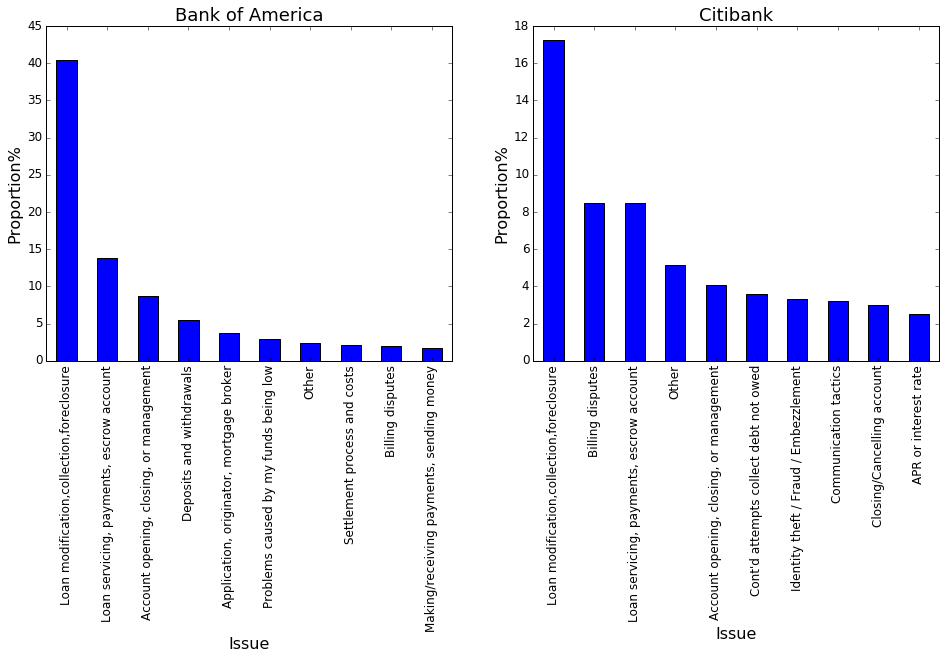

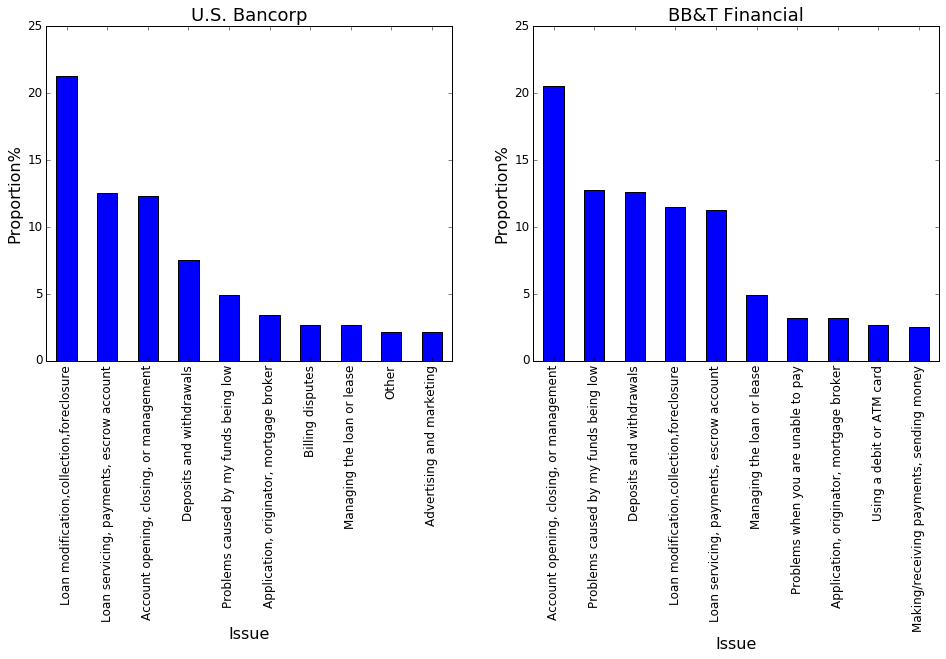

In [63]:
#create bar plots for the distribution of the Issue types that they encountered for comparison
for i,bank in enumerate(four_banks):
    if i%2==0:
        plot_two_graphs_together(i,complaints_4_banks,four_banks)

#### Comment:
Those 4 banks have encountered different combinations of issues. There are issues such as 'Account opening, closing, or management' and 'Loan modification, collection, foreclosure' that are common encountered in all of these banks, but there are also issues types that are common for bank but not common for another bank. Moreover, the distributions (percentage of each issue type) are different in those banks. Thus, my initial assumption is that different issues types might be intrinsically different in the way that they should be handled (like the level of difficulty, seriousness or complexity), and can result in different response time and and successful rate for the company to deal with. It is likely that different banks encountered different set of issues, and the issue types are the dominant factors that determine the performance of companies in timely response and successful solution to the complaint. So it is interesting to study whether issue types are more important for the company's performance, or there are other factors like whether some companies are constantly better at handling the complaints than other companies, regardless of the issue types.

#### ###Use Logistic Regression as a tool to test my hypotheses about difference in banking instituions' customer satisfaction

##### (1) Explore the dependence of likelihood of consumer disputed on other factors

In [64]:
#get the feature and response variables that will be used in logistic regression
X=complaints_4_banks_cleaned.iloc[:,[0,1,2,4]]
y_disputed=complaints_4_banks_cleaned.iloc[:,3] #y_disputed is the binary variable showing whether the consumer disputed

The categorical variable with multiple levels (>2) needs to be transformed into dummy variables in order to build the logistic regression model.

In [65]:
#transform the 'Company' column from categorical to dummy variable, treating 'Bank of America' as the baseline level
X1=pd.get_dummies(X.iloc[:,0]).drop(['Bank of America'],axis=1)
X1_new=pd.DataFrame.copy(X1)
X1_new['intercept']=1 #to build a logistic regression model using Python statsmodels library, we need to manually add the intercept column 
X1_new.head(10)

,BB&T Financial,Citibank,U.S. Bancorp,intercept
270557,0,0,1,1
270546,0,0,0,1
270544,0,0,0,1
270543,0,0,1,1
270331,0,0,0,1
130609,0,0,0,1
130610,0,0,0,1
130655,0,1,0,1
130657,1,0,0,1
130672,0,1,0,1


In [66]:
#transform the 'Issue' column from categorical to dummy variable, treating 'Bank of America' as the baseline level
X2=pd.get_dummies(X.iloc[:,1]).drop(['APR or interest rate'],axis=1)
X2_new=pd.DataFrame.copy(X2)
X2_new['intercept']=1
X2_new.head(10)

,"Account opening, closing, or management",Account terms and changes,Adding money,Advertising and marketing,"Advertising, marketing or disclosures",Application processing delay,"Application, originator, mortgage broker",Applied for loan/did not receive money,Arbitration,Balance transfer,...,Taking out the loan or lease,Taking/threatening an illegal action,Transaction issue,Unable to get credit report/credit score,Unauthorized transactions/trans. issues,Unexpected/Other fees,Unsolicited issuance of credit card,Using a debit or ATM card,Wrong amount charged or received,intercept
270557,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
270331,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
130672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
#X3 is 'Timely response?', since it's a binary variable, there is no need to transforming it into dummy variable
X3=X.iloc[:,[2]]
X3_new=pd.DataFrame.copy(X3)
X3_new['intercept']=1
X3_new.head(10)

,Timely response?,intercept
270557,0,1
270546,0,1
270544,0,1
270543,0,1
270331,0,1
130609,0,1
130610,0,1
130655,0,1
130657,0,1
130672,0,1


In [68]:
#transform the 'Company response to consumer' column from categorical to dummy variable,treating 'Closed' as the baseline level
X4=pd.get_dummies(X.iloc[:,3]).drop(['Closed'],axis=1)
X4_new=pd.DataFrame.copy(X4)
X4_new['intercept']=1
X4_new.head(10)

,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,intercept
270557,1,0,0,1
270546,1,0,0,1
270544,0,1,0,1
270543,1,0,0,1
270331,1,0,0,1
130609,1,0,0,1
130610,0,0,1,1
130655,1,0,0,1
130657,0,1,0,1
130672,0,1,0,1


In [69]:
#Check if Untimely response and consumer disputing rate are correlated by performing an Logistic Regression
#of 'Consumer disputed' on 'Untimely response'
logit_model_1=sm.Logit(y_disputed,X3_new)
result_1 = logit_model_1.fit()
result_1.summary()

Optimization terminated successfully.
         Current function value: 0.524487
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Consumer disputed?   No. Observations:                63527
Model:                          Logit   Df Residuals:                    63525
Method:                           MLE   Df Model:                            1
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:               1.750e-06
Time:                        23:22:17   Log-Likelihood:                -33319.
converged:                       True   LL-Null:                       -33319.
                                        LLR p-value:                    0.7328
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Timely response?    -0.0597      0.176     -0.339      0.734        -0.404     0.285
intercept           -1.2766      0.010   -132.674      0.000        -1.295    -1.258
====================================================================================
"""

Both the analysis of deviance (LLR p-value=0.7328) and the hypothesis test for the coefficient of the Untimely response show that timely response and consumer disputing rate are not correlated, which agrees with my initial hypothesis. 

In [70]:
#Next, check if the disputing rate varies by different companies
logit_model_2=sm.Logit(y_disputed, X1_new)
result_2 = logit_model_2.fit()
result_2.summary()

Optimization terminated successfully.
         Current function value: 0.524311
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Consumer disputed?   No. Observations:                63527
Model:                          Logit   Df Residuals:                    63523
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:               0.0003373
Time:                        23:22:21   Log-Likelihood:                -33308.
converged:                       True   LL-Null:                       -33319.
                                        LLR p-value:                 5.182e-05
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
BB&T Financial     0.1608      0.055      2.939      0.003         0.054     0.268
Citibank          -0.0698      0.022     -3.122      0.002        -0.114    -0.026
U.S. Bancorp       0.0217      0.031      0.704      0.481        -0.039     0.082
intercept         -1.2650      0.013   -100.198      0.000        -1.290    -1.240
==================================================================================
"""

Analysis of deviance (LLP p-value=5.182e-05) indicates that the differences among different banks are significant. The coefficients show that 'BB&T Financial' has a significantly higher disputing likelihood than 'Bank of America', while 'CitiBank' has a significantly lower disputing likelihood than 'Bank of America'. And 'U.S. Bancorp' has a slightly higher disputing rate than 'Bank of America', but the hypothesis test result shows that their difference might not be significant, so we might conclude that these two banks have equal performance in terms of consumer disputed. 
So the above result shows the conclusion (drawn from directly calculating from the data) that CitiBank is has the smallest dispute rate is statistically valid. But it is still not sufficient for explaining <b>why</b> one bank has a higher rate than the other. 

In [71]:
# Then, since Company might not be the only factor for different consumer disputing likelihood, we add another factor
# to the model: 'Company response to consumer', since how the company responded to the consumer is very likely to
# directly affect the consumer's reaction to their response
logit_model_3=sm.Logit(y_disputed,pd.concat([X1,X4_new],axis=1,join="outer"))
result_3 = logit_model_3.fit()
result_3.summary()

Optimization terminated successfully.
         Current function value: 0.517482
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Consumer disputed?   No. Observations:                63527
Model:                          Logit   Df Residuals:                    63520
Method:                           MLE   Df Model:                            6
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.01336
Time:                        23:22:24   Log-Likelihood:                -32874.
converged:                       True   LL-Null:                       -33319.
                                        LLR p-value:                5.289e-189
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
BB&T Financial                      0.0750      0.055      1.365      0.172        -0.033     0.183
Citibank                            0.0079      0.023      0.347      0.728        -0.037     0.052
U.S. Bancorp                        0.0530      0.031      1.705      0.088        -0.008     0.114
Closed with explanation             0.0071      0.082      0.086      0.932        -0.154     0.169
Closed with monetary relief        -0.9199      0.089    -10.281      0.000        -1.095    -0.745
Closed with non-monetary relief    -0.4613      0.087     -5.282      0.000        -0.633    -0.290
intercept                          -1.1530      0.082    -14.129      0.000        -1.313    -0.993
===================================================================================================
"""

The above model summary strongly indicates that the types of 'Company response to consumer' is correlated with the likelihood of consumer disputing, and the coefficients of different banks become not significant. The coefficient of 'Closed with monetary relief' is smallest, which indicates that for this type of company response the likelihood of consumer disputing is lowest. 'Close with non-monetary relief' has higher likelihood of consumer disputing, but is still lower than merely 'Close' or 'Closed with explanation'. All of this makes sense and it confirmed my initial assumption. Therefore, the difference in consumer disputing across the 4 banks can be attributed to the difference in the way in which they responded to the consumers. 

In [72]:
#Try the model which only includes the 'Company response to consumer'
logit_model_4=sm.Logit(y_disputed,X4_new)
result_4 = logit_model_4.fit()
result_4.summary()

Optimization terminated successfully.
         Current function value: 0.517517
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Consumer disputed?   No. Observations:                63527
Model:                          Logit   Df Residuals:                    63523
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.01329
Time:                        23:22:30   Log-Likelihood:                -32876.
converged:                       True   LL-Null:                       -33319.
                                        LLR p-value:                1.125e-191
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Closed with explanation             0.0146      0.082      0.178      0.859        -0.147     0.176
Closed with monetary relief        -0.9125      0.089    -10.249      0.000        -1.087    -0.738
Closed with non-monetary relief    -0.4562      0.087     -5.233      0.000        -0.627    -0.285
intercept                          -1.1495      0.082    -14.095      0.000        -1.309    -0.990
===================================================================================================
"""

In [73]:
#Perform analysis of deviance for model 3 (full model) and model 4 (reduced model)
1-stats.chi2.cdf(-2*(-32876-(-32874)),3) #p-value of the chi-square test, with DF (degree of freedom) = 3

0.26146412994911117

p-value of analysis of deviance is bigger than 0.05, so the 'Company' variable can be excluded from the model.

In [74]:
#Different types of company response might be attributed to the different types of issues the company needs to deal with,
#e.g. some issues are intrinsically harder to handle for the company than other issues, so they cound add to the likelihood
#of consumer disputing. So it is worthwhile to include the 'Issue' variable in the model
logit_model_5=sm.Logit(y_disputed,pd.concat([X2,X4_new],axis=1,join="outer"))
result_5 = logit_model_5.fit()
result_5.summary()

         Current function value: 0.514620
         Iterations: 35


/home/composersyf/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Consumer disputed?   No. Observations:                63527
Model:                          Logit   Df Residuals:                    63434
Method:                           MLE   Df Model:                           92
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.01881
Time:                        23:22:46   Log-Likelihood:                -32692.
converged:                      False   LL-Null:                       -33319.
                                        LLR p-value:                3.870e-203
============================================================================================================
                                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
Account opening, closing, or management     -0.0968      0.098     -0.984      0.325        -0.290     0.096
Account terms and changes                    0.0497      0.302      0.165      0.869        -0.541     0.641
Adding money                               -43.3920    3.5e+09  -1.24e-08      1.000     -6.86e+09  6.86e+09
Advertising and marketing                   -0.0380      0.145     -0.261      0.794        -0.323     0.247
Advertising, marketing or disclosures        0.3303      0.848      0.389      0.697        -1.332     1.993
Application processing delay                -0.3348      0.345     -0.970      0.332        -1.011     0.342
Application, originator, mortgage broker     0.1997      0.105      1.905      0.057        -0.006     0.405
Applied for loan/did not receive money      -0.1160      0.807     -0.144      0.886        -1.698     1.466
Arbitration                                  0.0451      0.341      0.132      0.895        -0.623     0.714
Balance transfer                             0.1325      0.215      0.617      0.537        -0.288     0.553
Balance transfer fee                        -0.5513      0.546     -1.009      0.313        -1.622     0.520
Bankruptcy                                   0.2444      0.299      0.818      0.414        -0.341     0.830
Billing disputes                             0.3145      0.104      3.032      0.002         0.111     0.518
Billing statement                            0.1082      0.144      0.752      0.452        -0.174     0.390
Can't contact lender                       -13.1764    476.184     -0.028      0.978      -946.480   920.128
Can't repay my loan                         -0.5323      0.315     -1.688      0.091        -1.151     0.086
Can't stop charges to bank account          12.1056    150.350      0.081      0.936      -282.575   306.786
Cash advance                                 0.0679      0.442      0.154      0.878        -0.798     0.934
Cash advance fee                             0.5038      0.426      1.182      0.237        -0.331     1.339
Charged bank acct wrong day or amt         -43.3920    3.5e+09  -1.24e-08      1.000     -6.86e+09  6.86e+09
Charged fees or interest I didn't expect    -0.0870      0.517     -0.168      0.866        -1.100     0.926
Closing/Cancelling account                   0.0951      0.118      0.805      0.421        -0.136     0.327
Collection debt dispute                      0.3521      0.254      1.386      0.166        -0.146     0.850
Collection practices                        -0.0249      0.289     -0.086      0.931        -0.591     0.541
Communication tactics                       -0.6104      0.139     -4.394      0.000        -0.883    -0.338
Cont'd attempts collect debt not owed       -0.0011      0.116     -0.009      0.993        -0.229     0.227
Convenience checks                           0.8309      0.460      1.808      0

In [75]:
#Perform analysis of deviance for model 5 (full model) and model 4 (reduced model)
1-stats.chi2.cdf(-2*(-32874-(-32692)),89) #p-value of the chi-square test, with DF (degree of freedom) = 89

0.0

Despite the fact that the logistic regression fitting procedure for model 5 did not converge within specified maximum number of iterations, the analysis of deviance suggests that the effects of Issue types are significant in the model and should not be ignored. 

In [76]:
logit_model_6=sm.Logit(y_disputed,pd.concat([X1,X2,X4_new],axis=1,join="outer"))
result_6 = logit_model_6.fit(method='bfgs')
result_6.summary()

         Current function value: 0.515382
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/composersyf/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     Consumer disputed?   No. Observations:                63527
Model:                          Logit   Df Residuals:                    63431
Method:                           MLE   Df Model:                           95
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.01736
Time:                        23:23:00   Log-Likelihood:                -32741.
converged:                      False   LL-Null:                       -33319.
                                        LLR p-value:                4.931e-182
============================================================================================================
                                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
BB&T Financial                               0.1307      0.057      2.307      0.021         0.020     0.242
Citibank                                    -0.0418      0.025     -1.684      0.092        -0.091     0.007
U.S. Bancorp                                 0.0927      0.032      2.929      0.003         0.031     0.155
Account opening, closing, or management     -0.1404      0.099     -1.419      0.156        -0.334     0.053
Account terms and changes                   -0.0015      0.303     -0.005      0.996        -0.596     0.593
Adding money                                -0.0039      1.570     -0.003      0.998        -3.081     3.073
Advertising and marketing                   -0.0538      0.145     -0.371      0.710        -0.338     0.230
Advertising, marketing or disclosures        0.0027      0.907      0.003      0.998        -1.775     1.780
Application processing delay                -0.0288      0.316     -0.091      0.928        -0.648     0.591
Application, originator, mortgage broker     0.1831      0.105      1.744      0.081        -0.023     0.389
Applied for loan/did not receive money      -0.0021      0.771     -0.003      0.998        -1.513     1.508
Arbitration                                 -0.0021      0.344     -0.006      0.995        -0.677     0.672
Balance transfer                             0.0082      0.220      0.037      0.970        -0.422     0.439
Balance transfer fee                        -0.0205      0.459     -0.045      0.964        -0.920     0.879
Bankruptcy                                   0.0156      0.314      0.050      0.960        -0.600     0.631
Billing disputes                             0.3628      0.103      3.512      0.000         0.160     0.565
Billing statement                            0.0190      0.146      0.130      0.896        -0.267     0.305
Can't contact lender                        -0.0137      0.858     -0.016      0.987        -1.696     1.669
Can't repay my loan                         -0.0544      0.275     -0.198      0.843        -0.592     0.484
Can't stop charges to bank account           0.0064      3.220      0.002      0.998        -6.304     6.317
Cash advance                                -0.0014      0.447     -0.003      0.997        -0.877     0.874
Cash advance fee                             0.0144      0.483      0.030      0.976        -0.932     0.961
Charged bank acct wrong day or amt          -0.0039      1.570     -0.003      0.998        -3.081     3.073
Charged fees or interest I didn't expect    -0.0035      0.506     -0.007      0.995        -0.994     0.987
Closing/Cancelling account                   0.0342      0.119      0.289      0.773        -0.198     0.267
Collection debt dispute                      0.0331      0.272      0.122      0.903        -0.500     0.566
Collection practices                        -0.0083      0.288     -0.029      0

In [77]:
#Perform analysis of deviance for model 6 (full model) and model 5 (reduced model)
1-stats.chi2.cdf(-2*(-32692-(-32741)),3) #p-value of the chi-square test, with DF (degree of freedom) = 3

1.0

The analysis of deviance rejects the hypothesis that 'Company' variable should be included in the final model, which contrasts with my initial hypothesis. 

In [78]:
# return all 'Company response to consumer' or 'Issue' types whose p-value of the coefficient is less than 0.05,
# using model 5 (including 'Company response to consumer' and 'Issue' as predictors)
pd.concat([result_5.params,result_5.pvalues],axis=1,join="outer")[result_5.pvalues<0.05]\
.rename(columns={0:'Coefficient',1:'p-value'})

,Coefficient,p-value
Billing disputes,0.314522,2.425519e-03
Communication tactics,-0.610372,1.112017e-05
Credit card protection / Debt protection,0.447153,1.901136e-03
Credit determination,0.279152,4.539737e-02
Credit reporting company's investigation,1.912193,2.869376e-02
Fraud or scam,0.486922,1.852108e-02
"Making/receiving payments, sending money",-0.266427,3.230748e-02
Payment to acct not credited,1.769556,2.430337e-02
Privacy,0.642870,1.787930e-02
Problems when you are unable to pay,-0.371040,3.121733e-02


Based on the above table, we can see that certain Issue types have a higher likelihood of ending up with a consumer dispute than others. 
#### Therefore, we might conclude that consumer dispute rate is strongly correlated with how the company responded to the consumer (response with monetary relief tends to result in a lower likelihood of consumer dispute), and it also depends on the particular Issue types encountered in some cases. After those two effects have been taken into consideration,  the difference between the 4 banks are not significant. 
#### Further discussion:
The reason why one bank is superior to the other banks in terms of lowering consumer dispute rate is very complicated. The above logistic regression analysis partly identified the factors that could attribute to higher dispute rate, like certain issue types are intrinsically prone to consumer dispute, and the way company responded. The explanation for the fact that the issue types encountered vary across different companies might be that companies have their own strengths and weaknesses in their financial services & product qualities. Also, the issue types and the way company responded to the issue are correlated as well. Certain issues apparently do not need monetary relief, or the response to such issue without monetary relief will not let the customer down, while others are obviously not. It is also likely that different companies have different standards of deciding which way they should respond to complaint cases. So we need more complicated models to study those effects, such as including the interaction terms between the features in the model. Due to the time constraints I am unable to dig deeper into these questions. In summary, the distribution of issue types and the different ways companies responded to the issue at least reflect some facts about how those companies differ in the way of handling complaints, but it is hard to tell exactly what factors make a company stand out in terms of reducing consumer disputes.

##### (2) Explore the dependence of likelihood of untimely response on other factors

In [79]:
#For this part, the column 'Consumer disputed?' will not be considered (as it is shown to be uncorrelated to untimely response),
#so we just need to remove the row in which the value is missing for 'Company response to consumer'
complaints_4_banks_cleaned_2=complaints_4_banks[~pd.isnull(complaints_4_banks['Company response to consumer'])]

In [80]:
#extract the feature and response variables that will be used in logistic regression
X_2=complaints_4_banks_cleaned_2.iloc[:,[0,1,4]]
y_untimely=complaints_4_banks_cleaned_2.iloc[:,2]

In [81]:
#transform the 'Company' column from categorical to dummy variable,treating 'Bank of America' as the baseline level
X1_2=pd.get_dummies(X_2.iloc[:,0]).drop(['Bank of America'],axis=1)
X1_2_new=pd.DataFrame.copy(X1_2)
X1_2_new['intercept']=1

In [82]:
#transform the 'Issue' column from categorical to dummy variable,treating 'APR or interest rate' as the baseline level
X2_2=pd.get_dummies(X_2.iloc[:,1]).drop(['APR or interest rate'],axis=1)
X2_2_new=pd.DataFrame.copy(X2_2)
X2_2_new['intercept']=1

In [83]:
#transform the 'Company response to consumer' column from categorical to dummy variable,treating 'Closed' as the baseline level
X4_2=pd.get_dummies(X_2.iloc[:,2]).drop(['Closed'],axis=1)
X4_2_new=pd.DataFrame.copy(X4_2)
X4_2_new['intercept']=1

In [84]:
#First, test if there are significant differences between the 4 banks in terms of timely response:
logit_model_7=sm.Logit(y_untimely,X1_2_new)
result_7 = logit_model_7.fit()
result_7.summary()

Optimization terminated successfully.
         Current function value: 0.023894
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Timely response?   No. Observations:                63588
Model:                          Logit   Df Residuals:                    63584
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.02722
Time:                        23:23:25   Log-Likelihood:                -1519.4
converged:                       True   LL-Null:                       -1561.9
                                        LLR p-value:                 2.545e-18
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
BB&T Financial     0.2753      0.328      0.840      0.401        -0.367     0.917
Citibank          -1.3855      0.250     -5.545      0.000        -1.875    -0.896
U.S. Bancorp       0.7571      0.152      4.982      0.000         0.459     1.055
intercept         -5.5128      0.083    -66.704      0.000        -5.675    -5.351
==================================================================================
"""

First, the analysis of deviance (LLR p-value) indicates that differences of timely response across difference companies are significant. Citibank has the best performance in terms of timely response, while U.S.Bancorp has the highest untimely response likelihood. The coefficient of BB&T is not significant, implying that although BB&T has a slightly worse performance than Bank of America in terms of timely response, statistically speaking this difference can be ignored.  

In [85]:
#Next, test if the untimely response rate is correlated with 'Company response to consumer':
logit_model_8=sm.Logit(y_untimely,X4_2_new)
result_8 = logit_model_8.fit()
result_8.summary()

Optimization terminated successfully.
         Current function value: 0.024472
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Timely response?   No. Observations:                63588
Model:                          Logit   Df Residuals:                    63584
Method:                           MLE   Df Model:                            3
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                0.003695
Time:                        23:23:29   Log-Likelihood:                -1556.1
converged:                       True   LL-Null:                       -1561.9
                                        LLR p-value:                  0.009130
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Closed with explanation            -0.8546      0.387     -2.207      0.027        -1.613    -0.096
Closed with monetary relief        -1.2589      0.444     -2.837      0.005        -2.128    -0.389
Closed with non-monetary relief    -0.5050      0.412     -1.225      0.220        -1.313     0.303
intercept                          -4.7597      0.380    -12.539      0.000        -5.504    -4.016
===================================================================================================
"""

The analysis of deviance (LLR p-value = 0.00913) does not strongly suggest that the untimely response rate is highly correlated with the 'Company response to consumer', although the 'Closed with monetary relief' response outcome has a less chance of being untimely, according to its coefficient. However, this finding contrasts with my initial hypothesis, however, it is not easy to come up with a good interpretation for this.  

In [86]:
#Then, add the 'Company response to consumer' variable to the model that already includes 'Company':
logit_model_9=sm.Logit(y_untimely,pd.concat([X1_2,X4_2_new],axis=1,join="outer"))
result_9 = logit_model_9.fit()
result_9.summary()

Optimization terminated successfully.
         Current function value: 0.023820
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Timely response?   No. Observations:                63588
Model:                          Logit   Df Residuals:                    63581
Method:                           MLE   Df Model:                            6
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.03022
Time:                        23:23:32   Log-Likelihood:                -1514.7
converged:                       True   LL-Null:                       -1561.9
                                        LLR p-value:                 3.682e-18
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
BB&T Financial                      0.3399      0.330      1.031      0.302        -0.306     0.986
Citibank                           -1.3433      0.251     -5.353      0.000        -1.835    -0.852
U.S. Bancorp                        0.7841      0.153      5.138      0.000         0.485     1.083
Closed with explanation            -0.8252      0.389     -2.122      0.034        -1.588    -0.063
Closed with monetary relief        -1.0760      0.447     -2.409      0.016        -1.951    -0.200
Closed with non-monetary relief    -0.4435      0.414     -1.072      0.284        -1.254     0.367
intercept                          -4.7478      0.380    -12.488      0.000        -5.493    -4.003
===================================================================================================
"""

In [87]:
#Analysis of deviance for the reduced model (model 7) and full model (model 9)
1-stats.chi2.cdf(-2*(-1519.4-(-1514.7)),3) #p-value for the chi-square test, DF=3

0.024419337395716334

The above result suggests that both 'Company' and 'Company response to consumer' needs to be included in the model

In [88]:
#Then, add the 'Issue' variable to the model that already includes 'Company' and 'Company response to consumer':
logit_model_10=sm.Logit(y_untimely,pd.concat([X1_2,X2_2,X4_2_new],axis=1,join="outer"))
result_10 = logit_model_10.fit(method='bfgs')
result_10.summary()

         Current function value: 0.023778
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/home/composersyf/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Timely response?   No. Observations:                63588
Model:                          Logit   Df Residuals:                    63492
Method:                           MLE   Df Model:                           95
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                 0.03196
Time:                        23:23:43   Log-Likelihood:                -1512.0
converged:                      False   LL-Null:                       -1561.9
                                        LLR p-value:                    0.3468
============================================================================================================
                                               coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
BB&T Financial                               0.0302      0.440      0.069      0.945        -0.832     0.892
Citibank                                    -1.6713      0.324     -5.161      0.000        -2.306    -1.037
U.S. Bancorp                                 0.9880      0.159      6.229      0.000         0.677     1.299
Account opening, closing, or management     -0.3600      0.823     -0.437      0.662        -1.974     1.254
Account terms and changes                   -0.0174      2.382     -0.007      0.994        -4.686     4.652
Adding money                                -0.0012      7.058     -0.000      1.000       -13.834    13.832
Advertising and marketing                   -0.1425      1.072     -0.133      0.894        -2.244     1.959
Advertising, marketing or disclosures       -0.0015      6.240     -0.000      1.000       -12.231    12.228
Application processing delay                -0.0140      2.810     -0.005      0.996        -5.521     5.493
Application, originator, mortgage broker    -0.2561      0.881     -0.291      0.771        -1.983     1.471
Applied for loan/did not receive money      -0.0021      4.546     -0.000      1.000        -8.913     8.908
Arbitration                                 -0.0159      2.783     -0.006      0.995        -5.470     5.438
Balance transfer                            -0.0458      1.735     -0.026      0.979        -3.446     3.355
Balance transfer fee                        -0.0101      3.425     -0.003      0.998        -6.723     6.703
Bankruptcy                                  -0.0162      2.614     -0.006      0.995        -5.140     5.108
Billing disputes                            -0.3445      0.942     -0.366      0.715        -2.190     1.502
Billing statement                           -0.1207      1.393     -0.087      0.931        -2.852     2.610
Can't contact lender                        -0.0020      8.289     -0.000      1.000       -16.247    16.243
Can't repay my loan                         -0.0165      2.194     -0.008      0.994        -4.317     4.284
Can't stop charges to bank account          -0.0002     49.764  -4.79e-06      1.000       -97.535    97.535
Cash advance                                -0.0105      3.188     -0.003      0.997        -6.260     6.239
Cash advance fee                            -0.0113      3.773     -0.003      0.998        -7.406     7.383
Charged bank acct wrong day or amt          -0.0012      7.058     -0.000      1.000       -13.834    13.832
Charged fees or interest I didn't expect    -0.0035      5.146     -0.001      0.999       -10.089    10.082
Closing/Cancelling account                  -0.1517      1.040     -0.146      0.884        -2.190     1.887
Collection debt dispute                     -0.0238      2.460     -0.010      0.992        -4.845     4.797
Collection practices                        -0.0188      2.748     -0.007      0

In [89]:
#Analysis of deviance for the reduced model (model 9) and full model (model 10)
1-stats.chi2.cdf(-2*(-1514.7-(-1512.0)),89) #p-value for the chi-square test, DF=89

1.0

The fitting procedure for the above model did not converge. Plus, the result of analysis of deviance (p-value=1) suggests that it is NOT necessary to include the "Issue" variable in the model. This contrasts with my initial hypothesis that some Issue types intrisically lead to higher untimely response rate than others. It is also different from the effect of Issue types on the consumer dispute rate as found previously. 
#### Therefore, we might conclude that untimely response rate varies across different companies, and is slightly correlated with how the company responded to the consumer (whether it is monetary relief or not), but does not depend on the Issue type of the complaint.  
#### Further discussion:
Since it turned out that the untimely response rate is not correlated with Issue types, it is very likely that some companies are better about responding to complaints in a timely fashion as compared to other companies. The superiority might be partly due to the way company responded to complaints (e.g. Closed with monetary relief). But there could be other hidden factors that are not available in the data used in this case study, so we still do not know the exact reasons why certain companies are superior in timely response. Even though the untimely response rate does not depend on the issue types, we do not know the average diffculty and complexity level of issues each company has been dealing with, so it cannont be denied that some companies encountered a few special issues which took unexpectedly longer time to solve, but they are generally not bad at timely response to complaint. 

## Problem 4

<b>Comment:</b> Since it is hard or even impossible to get the total number of customers for each company, the customer satisfaction leaderboard that I am going to build in this case study is limited to estimating the customer satisfaction in terms of company's feedback or response to the complaints. But complaints per number of customers is clearly a much better metric for evaluating customer satisfaction, while this case study (since we are required to only use the data from the CFPD database) only focuses on whether those dissatisfied customers (who submitted the complaints) are satisfied with companies' response to their complaints. 

In <b>Problem 3</b>, we concluded that 'untimely response rate' and 'consumer dispute rate' are the two measures from the CFPB database that are directly related to the customer's dissatisfaction level. For each company, we can calculate the average occurrences of untimely response and consumer dispute per complaint and use them as the metrics for comparing the performance of different companies. 'Timely response?' does not have missing values, so we could simply calculate its mean value for each company. While the 'Consumer disputed?' column contains some missing values, so the missing value imputation method needs to be applied to the column for improved estimation accuracy. 

In [90]:
#Take the subset of the original data (2013.01 - 2015.12)
complaints_2=complaints_1.loc[:,['Company','Issue','Company response to consumer','Timely response?','Consumer disputed?']]
complaints_2.head(15)

,Company,Issue,Company response to consumer,Timely response?,Consumer disputed?
550513,Equifax,Incorrect information on credit report,Closed with explanation,Yes,No
270582,Wells Fargo & Company,"Loan modification,collection,foreclosure",Closed with explanation,Yes,No
270576,Experian,Incorrect information on credit report,Closed with explanation,Yes,No
270571,"Bayview Loan Servicing, LLC",Other,Closed with explanation,Yes,No
270570,"Seterus, Inc.","Loan modification,collection,foreclosure",Closed with explanation,Yes,No
270569,TD Bank US Holding Company,"Account opening, closing, or management",Closed with explanation,Yes,No
270557,U.S. Bancorp,"Account opening, closing, or management",Closed with explanation,Yes,No
270546,Bank of America,"Loan modification,collection,foreclosure",Closed with explanation,Yes,No
270544,Bank of America,"Making/receiving payments, sending money",Closed with monetary relief,Yes,No
270543,U.S. Bancorp,"Making/receiving payments, sending money",Closed with explanation,Yes,No


In [91]:
# Similar as Problem 3, transform the categorical variables into binary (0 or 1) variables
complaints_2.loc[:,'Timely response?']=complaints_2['Timely response?'].apply(encode_categorical_variable,args=(True,))
complaints_2.loc[:,'Consumer disputed?']=complaints_2['Consumer disputed?'].apply(encode_categorical_variable)

In <b>Problem 3</b>, it was concluded that both Issue types and the way company responded to the consumer can affect the consumer disputed rate. Basically, there are two types of missing values. For type 1, both the 'Consumer disputed?' and 'Company response to consumer' are missing for the complaint. So only the 'Issue' value can be relied on to estimate the 'Consumer disputed?' value. The value is either 1 or 0, since it is missing, it can be replaced by its expected value (a value between 0 and 1). So the mean 'Consumer disputed?' value for all complaints belonging to the Issue type that is the same as the Issue type of this particular missing 'Consumer disputed?' can serve as a good replacement. Likewise, for type 2, only 'Consumer disputed?' is missing, while both 'Issue' and 'Company response to consumer' are available, so the complaints can be divided into different categories based on each unique ('Issue','Consumer disputed?') pair (for instance, ('APR or interest rate','Closed with explanation'), and the missing values can be replaced by the mean value of 'Consumer disputed?' for all cases within the same category. 

In [92]:
#Imputing Type 1 missing value in 'Consumer disputed?'
two_missing_values_indices=np.where(np.array(pd.isnull(complaints_2['Company response to consumer']))\
                                    & np.array(pd.isnull(complaints_2['Consumer disputed?'])))[0]
len(two_missing_values_indices) #number of Type 1 missing value cases

1732

In [93]:
avg_dispute_rate_1=complaints_2.groupby(['Issue']).mean() #calculate the mean value of 'Consumer disputed?' for each Issue type
#Loop through every type 1 missing value, look up the corresponding mean value for its Issue type, and impute the missing value
for i in two_missing_values_indices:
    issue_type=complaints_2.iloc[i,1]
    complaints_2.iloc[i,4]=avg_dispute_rate_1.ix[issue_type,1]    

In [94]:
#Imputing Type 2 missing value in 'Consumer disputed?'
one_missing_value_indices=np.where(pd.isnull(complaints_2['Consumer disputed?']))[0]
len(one_missing_value_indices) #number of Type 2 missing value cases

3860

In [95]:
#calculate the mean value of 'Consumer disputed?' for each (Issue,Company response to consumer) type
avg_dispute_rate_2=complaints_2.groupby(['Issue','Company response to consumer']).mean()
#Similar as looping through type 1 missing values
for i in one_missing_value_indices:
    issue_response_type=tuple(complaints_2.iloc[i,[1,2]])
    complaints_2.iloc[i,4]=avg_dispute_rate_2.loc[issue_response_type,'Consumer disputed?'] 

A lot of companies in the CFPB database do not have many cases of receiving complaints, so if the total number of complaints is too small, it is very hard to get a statistically robust estimation of the untimely response rate and consumer dispute rate. For example, both untimely response and consumer dispute are minority cases in the database, so if a company does not get many complaints, it is very likely that the company does not have any untimely response or get any dispute, and its performance score will be 100%. But in fact, it might just happen by chance, so if there were larger number of complaints submitted for this company, their true customer satisfaction performance will be revealed, and might be even much lower than others. Therefore, in this case any company with less than <b>30</b> complaints during 2013.01 - 2015.12 will not be ranked. Instead, only their raw data in terms of untimely response rate and consumer dispute rate will be included in the leaderboard.  

In [96]:
num_of_complaints=complaints_2.groupby(['Company']).size()
company_list=list(num_of_complaints[num_of_complaints>=30].index)
len(company_list) #number of companies which have at least 30 complaints in total

669

In [97]:
#subset the companies with at least 30 complaints to build the leaderboard
complaints_3=pd.DataFrame.copy(complaints_2[complaints_2.Company.apply(is_element, args=(company_list,))])

In [98]:
#calculate the expected untimely response rate and consumer dispute rate per complaint case
consumer_dissatisfy_1=complaints_3.groupby(['Company']).mean().rename(columns={'Timely response?':'untimely response rate',
                                                                            'Consumer disputed?':'consumer dispute rate'})
consumer_dissatisfy_2=pd.DataFrame({'number of complaints':complaints_3.groupby(['Company']).size()})
consumer_dissatisfy=pd.concat([consumer_dissatisfy_2,consumer_dissatisfy_1],axis=1,join='outer')
consumer_dissatisfy.head(15)

,number of complaints,untimely response rate,consumer dispute rate
Company,,,
1st Franklin Financial Corporation,38,0.052632,0.236842
21st Mortgage Corporation,199,0.000000,0.247150
"A.R.M. Solutions, Inc.",37,0.081081,0.081081
AALM Consulting Services LTD (International company),52,0.153846,0.157629
ACE Cash Express Inc.,487,0.030801,0.110883
ACS Education Services,307,0.019544,0.267101
AES/PHEAA,1303,0.000767,0.237318
"AMCOL Systems, Inc.",96,0.145833,0.218750
"AR Resources, Inc.",75,0.093333,0.230015


We use the linear combination of the average untimely response rate and average consumer dispute rate to estimate the overall consumer dissatisfaction score with company's responses. Of course, the lower the dissatisfaction score, the higher the rank of the company. Since the consumer's dissatisfaction level is unknown to us, currently there is no way we could tell which rate is more important to the dissatisfaction level. Different customers may assign different weights to each rate. So we just make this assumption that the two rates are equally important in estimation. However, if we have some prior domain knowledge about the relative importance of the two rates or we have some survey data which include the quantitative measure of the customer dissatisfaction level, then we could obtain more reasonable values for the weights w1 and w2 (e.g. through supervised learning). 

In [99]:
w1=0.5
w2=0.5
consumer_dissatisfy['dissatisfaction score']=w1*consumer_dissatisfy['untimely response rate']\
+w2*consumer_dissatisfy['consumer dispute rate']

Sort the leaderboard primarily by the dissatisfaction score; if two companies' dissatisfaction score are equal to other, then the company whose total number of complaints is bigger should rank first. Since the more complaints we have, the more reliable we can estimate its dissatisfaction score in terms of getting back to dissatisfied customers. 

In [100]:
leaderboard_1=consumer_dissatisfy.sort_values(['dissatisfaction score','number of complaints'],ascending=[True,False])

In [101]:
#Add a new column named 'rank' to show the rank of those companies on the leaderboard
leaderboard_1['rank']=list(range(1,leaderboard_1.shape[0]+1))
leaderboard_1.loc[:,'rank']=leaderboard_1.loc[:,'rank'].astype(str)

In [102]:
#Find the companies with less than 30 total number of complaints
complaints_less_than_30=pd.DataFrame.copy(complaints_2[~complaints_2.Company.apply(is_element, args=(company_list,))])
print(complaints_less_than_30.shape)
print(len(np.unique(complaints_less_than_30.Company)))

(17096, 5)
2720


2720 companies have less than 30 complaints. The sum of the number of complaints for those companies is only 17,096.

In [103]:
#create the summary table for the companies with less than 30 complaints, including the 'number of complaints',
#'untimely response rate' and 'consumer dispute rate'
consumer_dissatisfy_4=complaints_less_than_30.groupby(['Company']).mean().rename(columns={'Timely response?':'untimely response rate',\
                                                                                'Consumer disputed?':'consumer dispute rate'})
consumer_dissatisfy_5=pd.DataFrame({'number of complaints':complaints_less_than_30.groupby(['Company']).size()})
consumer_dissatisfy_6=pd.concat([consumer_dissatisfy_5,consumer_dissatisfy_4],axis=1,join='outer')

In [104]:
#concatenate the leaderboard that includes all companies with more than 30 complaints with the summary table for
#the rest of the companies
leaderboard_final=pd.concat([leaderboard_1,consumer_dissatisfy_6],axis=0,join='outer')
na_rank_indices=np.where(pd.isnull(leaderboard_final['rank']))[0]
leaderboard_final.ix[na_rank_indices,'rank']="NOT ranked"
leaderboard_final.ix[na_rank_indices,'dissatisfaction score']="NOT Available"
leaderboard_final=leaderboard_final.loc[:,['rank','number of complaints','untimely response rate','consumer dispute rate','dissatisfaction score']]

In [105]:
#Top 20 companies with the best customer satisfaction
leaderboard_final.head(20)

,rank,number of complaints,untimely response rate,consumer dispute rate,dissatisfaction score
Company,,,,,
United PanAm Financial Corp.,1,46,0.000000,0.021739,0.0108696
"Empowerment Ventures, LLC",2,871,0.001148,0.033295,0.0172216
"Credit Karma, Inc.",3,78,0.000000,0.038462,0.0192308
The Law Offices of Mitchell D. Bluhm & Associates,4,49,0.000000,0.040816,0.0204082
Turning Point Solutions LLC,5,109,0.009174,0.045872,0.0275229
Factual Data,6,37,0.000000,0.058996,0.0294981
"Mel S. Harris and Associates, LLC",7,33,0.000000,0.060606,0.030303
"Media Collections, Inc",8,49,0.020408,0.040816,0.0306122
"I.C. System, Inc.",9,789,0.002535,0.059569,0.031052


In [106]:
#the companies at the bottom of the entire leaderboard: they are not ranked since their total number of complaints is
#smaller than 30
leaderboard_final.tail(20)

,rank,number of complaints,untimely response rate,consumer dispute rate,dissatisfaction score
Company,,,,,
Worth Finance Corporation,NOT ranked,8,0.000000,0.125000,NOT Available
Wright & Lerch Attorneys At Law,NOT ranked,11,0.000000,0.272727,NOT Available
"Wyndham Capital Mortgage, Inc.",NOT ranked,13,0.000000,0.230769,NOT Available
Xtreme Products LLC,NOT ranked,1,1.000000,0.000000,NOT Available
"Yakima County Credit Service, INC",NOT ranked,2,0.000000,0.500000,NOT Available
Yale Mortgage Corporation,NOT ranked,16,0.062500,0.264247,NOT Available
"ZENCO COLLECTION, LLC",NOT ranked,15,0.000000,0.133333,NOT Available
"ZOA, LLC",NOT ranked,6,0.666667,0.248369,NOT Available
"Zakheim Law Group, P.A.",NOT ranked,20,0.000000,0.250000,NOT Available


In [107]:
#20 companies with the worst customer satisfaction (filter out the unranked companies)
leaderboard_final[leaderboard_final['rank']!='NOT ranked'].tail(20)

,rank,number of complaints,untimely response rate,consumer dispute rate,dissatisfaction score
Company,,,,,
National Arbitration Forum,650,36,0.555556,0.166667,0.361111
"BAM Financial, LLC",651,41,0.341463,0.393670,0.367567
"Duncan Solutions, lnc.",652,31,0.612903,0.161290,0.387097
"Lazarus Financial Group, Inc.",653,34,0.529412,0.246679,0.388045
Scottrade Bank,654,166,0.000000,0.783133,0.391566
"The Thomas Agency, Inc.",655,41,0.560976,0.229397,0.395186
Google Inc.,656,67,0.417910,0.379124,0.398517
"P&B Capital Group, LLC",657,54,0.611111,0.222902,0.417007
Premier Recovery Group,658,137,0.824818,0.015673,0.420245


<b>Conclusion:</b><br>
<b>Shortingcomings</b> of the metric:<br>
1. First, as mentioned above, this metric only measures the satisfaction level of the customers who were already dissatified with the company and sent the complaint to CFPB, so it is far from estimating the more important part of customer satisfaction, that is the complaint rate per number of customers. Therefore its scope must be explicitly defined. This is mostly due to the lack of total number of customers data for most companies. <br>
2. We include both untimely response rate and consumer dispute rate and give them equal weight when calculating the dissatisfaction score. In reality this is a too simplistic approximation. If we were able to collect the customer's level of dissatisfaction (0 - 10 scale, for example), that will help better understand which rate is more important. <br>
3. The metric does not consider the fact that the level of dissatisfaction can vary a lot across difference cases. Slight dissatisfaction and extreme dissatisfaction can be quite different in terms of measuring the customer's level of satisfaction. But using the metric proposed these two cases will have equal importance in terms of evaluating satisfaction. So the dispute action done by the consumer does not reflect how dissatisfied with the company. Also, the satisfaction level also depends on the actual issues encountered. <br>
4. Many of the companies have very rare complaint cases report to CFPB. Even when the companies with a total of complaints less than 30 are excluded, the companies with relatively less complaints reported still cannot give a very good estimation of their dissatisfaction score. <br>
5. It is almost impossible to evaluate the performance (e.g. accuracy) of this metric in building the leaderboard. If the above shortcomings significantly affect the ranking in the leaderboard, it can be misleading when the results are used by other people or organizations. Unless we have another reliable source based on which we could evaluate the metric performance, it is hard to improve the performance metric and leaderboard. <br>
6. Customer satisfaction is a very subjective concept. Even if we get the data to calculate the complaint rate, there is still uncertainty within the level of dissatisfaction for each complaint. And we lack the objective way of weighing the relative importance of overall dissatisfaction rate and dissatisfaction level with company's response and feedback. <br>

<b>Strengths</b> of the metric:<br>
- It is a very intuitive metric, and is very easy and fast to implement as it does not require us to build sophisticated models and tune parameters. <br>
- It takes two very import factors in terms of estimating the satisfaction level of the consumer with the company's response to their complaint. Although treating the two factors equally is too simplistic, it is the most reasonable thing we could do when we do not have additional information. <br>
- It made full use of the data in the CFPB database and the relationships between different columns of the data inferred from the data. <br>
- It has a way of dealing with the missing values within the 'Company response to consumer' column, which could improve the evaluation accuracy. 